In [ ]:
import cv2
import os
import glob

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import pandas as pd
import torch # PyTorch package
from torch.utils.data import Dataset, DataLoader
import torchvision # load datasets
import torchvision.transforms as transforms # transform data
from torchvision import datasets, transforms, models
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer
from PIL import Image

In [ ]:
def video_to_image(image_class: str, skip_frame: int, p: float, q: float):
    """
    A function that generates images from video clips folder.
    Split the image into train, validation, and test folder based on a given probability.
    -------------------------
    image_class: A string which indicates the type of the image that is to be generated from the video (i.e. 'Main' or 'Other').
    skip_frame: An integer which indicates the number of frames to skip.
    p: A float which indicates train set proportion.
    q: A float which indicates validation set proportion.

    """

    video_list = glob.glob("media/video_clips/" + image_class + "*")
    count = 0

    np.random.seed(0)
    for i in video_list:
        cam = cv2.VideoCapture(i)
        curr_frame = 0
        while cam.isOpened():
            ret, frame = cam.read()
            if ret:
                count += 1
                #randomly select image into train/valid/test set
                file_name = image_class+ str(count) + ".jpg"
                set_index = np.random.choice(np.arange(0, 3), p=[p, q, 1-p-q])
                if set_index == 0:
                    file_path = "media/images/train/" + image_class + "/" + file_name
                elif set_index == 1:
                    file_path = "media/images/validation/" + image_class + "/" + file_name
                else:
                    file_path = "media/images/test/" + image_class + "/" + file_name
                cv2.imwrite(file_path, frame)
                curr_frame += skip_frame
                cam.set(cv2.CAP_PROP_POS_FRAMES, curr_frame)

            else:
                cam.release()
                break
    print("Generate " + str(count) + " " + image_class + " images.")




In [ ]:
video_to_image("Main", 30, 0.7, 0.1)

Generate 613 Main images.


In [ ]:
video_to_image("Other", 30, 0.7, 0.1)

Generate 1370 Other images.


In [ ]:
input_path = "media/images/"

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
    'test':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'train':
    datasets.ImageFolder(input_path + 'train', data_transforms['train']),
    'validation':
    datasets.ImageFolder(input_path + 'validation', data_transforms['validation']),
    'test':
    datasets.ImageFolder(input_path + 'test', data_transforms['test'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=0),
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=False,
                                num_workers=0),
    'test':
    torch.utils.data.DataLoader(image_datasets['test'],
                                batch_size=32,
                                shuffle=False,
                                num_workers=0)
}

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
model = models.resnet50(pretrained=True).to(device)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

/Users/ruochenchen/anaconda3/envs/dreamfight/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ruochenchen/anaconda3/envs/dreamfight/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [ ]:
model_trained = train_model(model, criterion, optimizer, num_epochs=3)

Epoch 1/3
----------


: 

: 

In [ ]:
torch.save(model_trained.state_dict(), 'models/pytorch/weights.h5')

In [ ]:
model = models.resnet50(pretrained=False).to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)
model.load_state_dict(torch.load('models/pytorch/weights.h5'))

/Users/ruochenchen/anaconda3/envs/dreamfight/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
test_img_paths = glob.glob("media/images/test/Main/*") + glob.glob("media/images/test/Other/*")
img_list = [Image.open(img_path) for img_path in test_img_paths]
test_batch = torch.stack([data_transforms['test'](img).to(device)
                                for img in img_list])
pred_logits_tensor = model(test_batch)
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()


: 

: 

In [ ]:
correct = sum([test_img_paths[idx].split('/')[2]==np.where(pred_probs[idx,0]>pred_probs[idx,1], 'Main', 'Other') for idx in range(len(test_img_paths))])

print('Test Accuracy of the model: {} out of {} correct labeling'.format(correct, len(test_img_paths)))
print('Test Accuracy of the model: {} %'.format(100 * correct / len(test_img_paths)))

Test Accuracy of the model: 408 out of 409 correct labeling
Test Accuracy of the model: 99.75550122249389 %


In [ ]:
error_index = [idx for idx in range(len(test_img_paths)) if test_img_paths[idx].split('/')[2]!=np.where(pred_probs[idx,0]>pred_probs[idx,1], 'Main', 'Other') ]
error_img = [(i,test_img_paths[i]) for i in error_index]
error_img

[(264, 'images/test/Other/Other835.jpg')]

Text(0.5, 1.0, '100% Main, 0% Other')

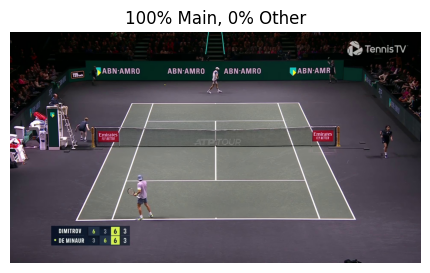

In [ ]:
fig,ax = plt.subplots(1,1,figsize = (6,3))
ax.axis('off')
ax.imshow(img.imread(error_img[0][1]))
ax.set_title("{:.0f}% Main, {:.0f}% Other".format(100*pred_probs[error_img[0][0],0],
                                                            100*pred_probs[error_img[0][0],1]))

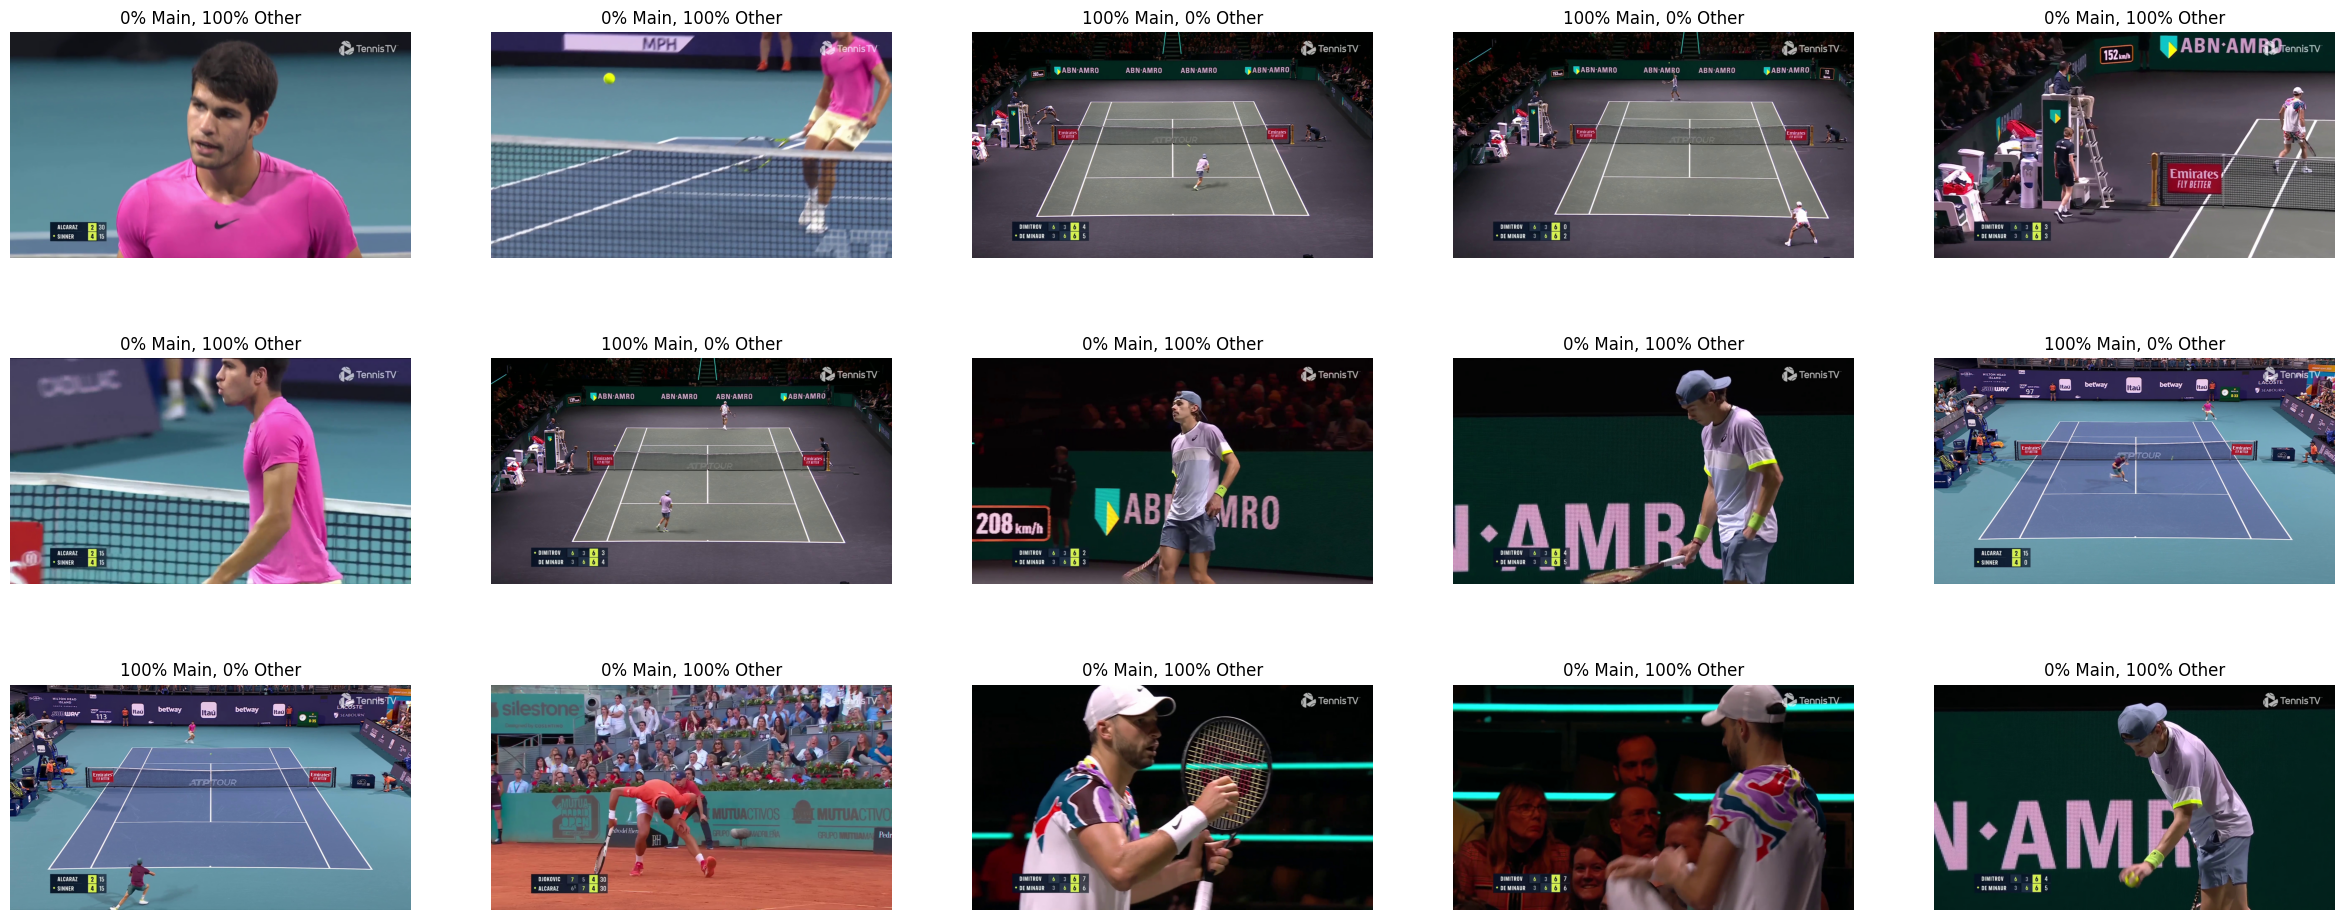

In [ ]:
import random
plt.figure(figsize=(30,12))
for i in range(15):
    idx = random.randint(0, len(img_list))
    image = img_list[idx]
    ax=plt.subplot(3,5,i+1) # create an axis
    ax.axis('off')
    ax.set_title("{:.0f}% Main, {:.0f}% Other".format(100*pred_probs[idx,0],
                                                            100*pred_probs[idx,1]))
    plt.imshow(image) # show the img

In [ ]:
test_other_img_paths = ["media/images/test/Other/Other970.jpg",
                        "media/images/test/Main/Main14.jpg"]
test_other_img_list = [Image.open(img_path) for img_path in test_other_img_paths]
test_other_batch = torch.stack([data_transforms['test'](img).to(device)
                                for img in test_other_img_list])
pred_other_logits_tensor = model(test_other_batch)
pred_other_probs = F.softmax(pred_other_logits_tensor, dim=1).cpu().data.numpy()
print(pred_other_probs)

: 

: 

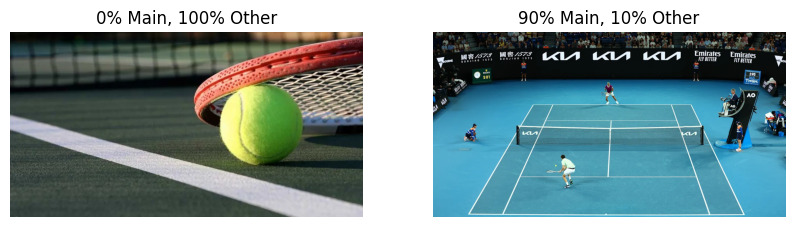

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for i, img in enumerate(test_other_img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Main, {:.0f}% Other".format(100*pred_other_probs[i,0],
                                                            100*pred_other_probs[i,1]))
    ax.imshow(img)

In [ ]:
# import the necessary packages
from collections import deque
import torch
import numpy as np
import argparse
import cv2
from PIL import Image

In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device
model = models.resnet50(pretrained=False).to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)
model.load_state_dict(torch.load('models/pytorch/weights.h5'))

Q = deque(maxlen=15)

/Users/ruochenchen/anaconda3/envs/dreamfight/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
vs = cv2.VideoCapture('media/video_clips/Main_clip1.mp4')
writer = None
(W, H) = (None, None)
# loop over frames from the video file stream
while True:
	# read the next frame from the file
	(grabbed, frame) = vs.read()
	output = frame.copy()

	frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
	frame = Image.fromarray(frame)
	test_batch = torch.stack([data_transforms['test'](frame).to(device)])
	pred_logits_tensor = model(test_batch)
	#pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
	#print(pred_probs)
	break
	# # if the frame was not grabbed, then we have reached the end
	# # of the stream
	# if not grabbed:
	# 	break
	# # if the frame dimensions are empty, grab them
	# if W is None or H is None:
	# 	(H, W) = frame.shape[:2]

# 	preds = model.predict(np.expand_dims(frame, axis=0))[0]
# 	Q.append(preds)
# 	# perform prediction averaging over the current history of
# 	# previous predictions
# 	results = np.array(Q).mean(axis=0)
# 	i = np.argmax(results)
# 	label = lb.classes_[i]

# 	# draw the activity on the output frame
# 	text = "view: {}".format(label)
# 	cv2.putText(output, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX,
# 		1.25, (0, 255, 0), 5)
# 	# check if the video writer is None
# 	if writer is None:
# 		# initialize our video writer
# 		fourcc = cv2.VideoWriter_fourcc(*"MJPG")
# 		writer = cv2.VideoWriter(args["output"], fourcc, 50,
# 			(W, H), True)
# 	# write the output frame to disk
# 	writer.write(output)
# 	# show the output image
# 	cv2.imshow("Output", output)
# 	key = cv2.waitKey(1) & 0xFF
# 	# if the `q` key was pressed, break from the loop
# 	if key == ord("q"):
# 		break
# # release the file pointers
# print("[INFO] cleaning up...")
# writer.release()
# vs.release()

: 

: 

In [ ]:
test_img_paths = glob.glob("media/images/test/Main/*") + glob.glob("media/images/test/Other/*")
img_list = [Image.open(img_path) for img_path in test_img_paths]
img_list


[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x1080>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x1080>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x1080>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x1080>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x1080>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x1080>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x1080>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x1080>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x1080>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x1080>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x1080>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x1080>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x1080>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x1080>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=R

In [ ]:

test_batch = torch.stack([data_transforms['test'](img).to(device)
                                for img in img_list])
pred_logits_tensor = model(test_batch)
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()

correct = sum([test_img_paths[idx].split('/')[2]==np.where(pred_probs[idx,0]>pred_probs[idx,1], 'Main', 'Other') for idx in range(len(test_img_paths))])
